# MPC Example Using Scipy optimization
reference: 

https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html

To Do:

Create NL model; create function to simulate response to input; 


In [93]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

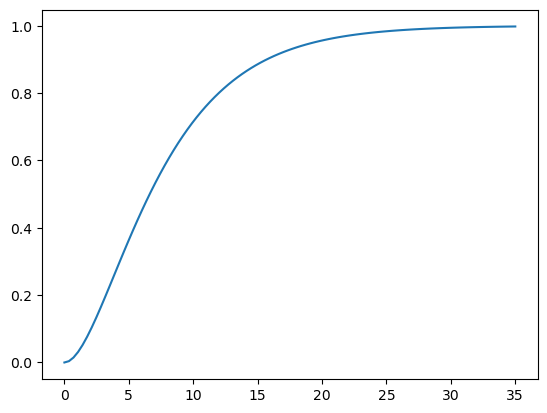

In [94]:
G = scipy.signal.lti([1], [15, 8, 1])
plt.plot(*G.step());

In [95]:
M = 10  # Control horizon
P = 100  # Prediction horizon
DeltaT = 1  # Sampling rate
tcontinuous = np.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = np.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

# first order reference trajectory
tau_c = 1
r = 1 - np.exp(-tpredict/tau_c)  

u = np.ones(M)  # initial guess for optimized control

x0 = np.zeros(G.to_ss().A.shape[0])  # Initial system state

In [96]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [97]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

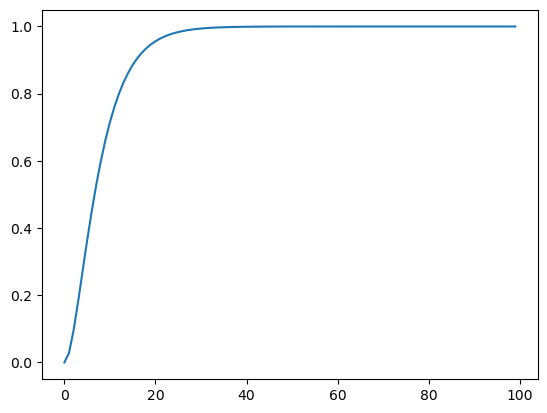

In [98]:
plt.plot(tpredict, prediction(extend(u)));


In [113]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(np.abs(np.diff(u)))
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish

In [114]:
objective(u)

3.5129108394072572

In [115]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

0.0009572860493894071

In [116]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]


In [117]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.grid()
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.grid()
    plt.legend()

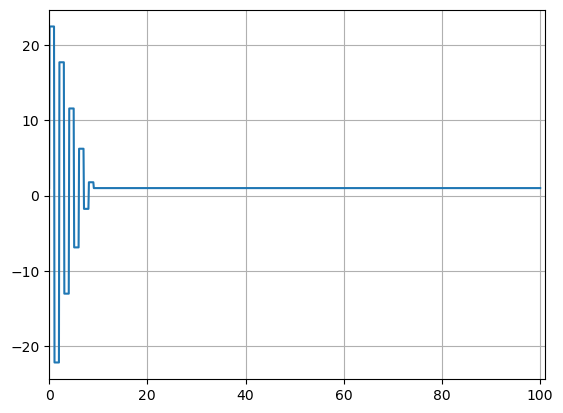

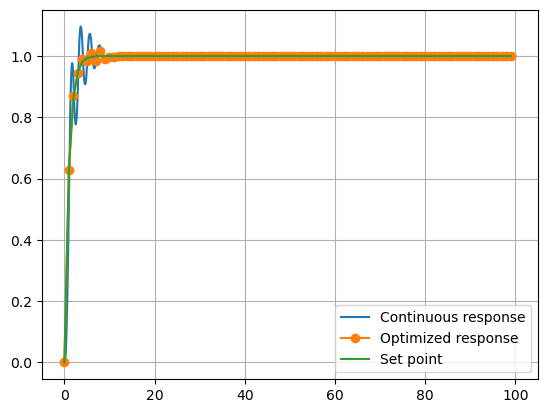

In [118]:
plotoutput(ucont, uopt)

### Simple NL MPC Model

Stable continuous nonlinear model: <br /> 
$\dot{x} = -x^{3} + u$

In discrete time using finite difference: <br /> 
$x[k+1] = x[k] - \Delta T x[k]^{3} + \Delta T u[k]$

1.2599184304482562

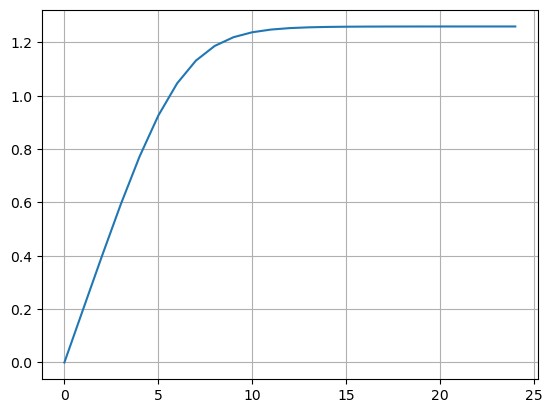

In [18]:
x = np.zeros(25)
u = 2*np.ones(25)
dt = 0.1
for k in range(len(x)-1):
    x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
plt.plot(x)
plt.grid()
x[-1]

In [21]:
x0 = 0
dt = 0.1

In [22]:
def nl_prediction(u, dt, x0=x0):
    """Predict the effect of an input signal"""
    x = np.empty(len(u))
    x[0] = x0
    for k in range(len(x)-1):
        x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
    return x

1.2599184304482562

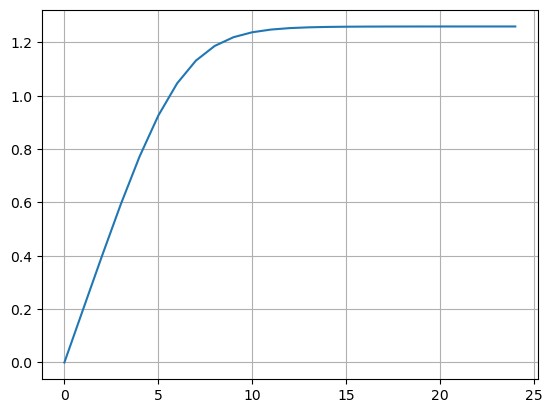

In [23]:
x = np.zeros(25)
u = 2*np.ones(25)
dt = 0.1
x = nl_prediction(u, dt, 0)
plt.plot(x)
plt.grid()
x[-1]

In [79]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = nl_prediction(extend(u), dt)
    
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(np.abs(np.diff(u)))
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.00*movepenalty + 0.*strongfinish

In [80]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

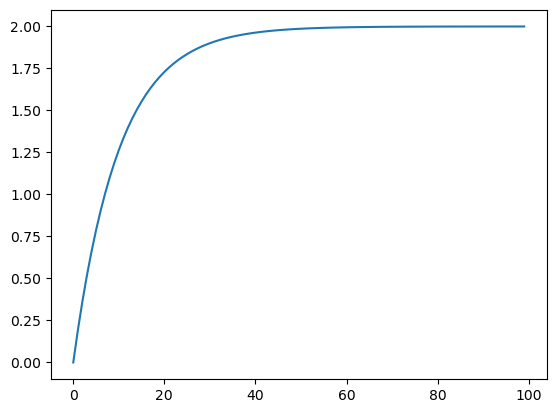

In [87]:
M = 50 
P = 100

# first order reference trajectory
tau_c = 1
tpredict = np.arange(0, P*dt, dt)   # discrete points at prediction horizon
r = 2 - 2*np.exp(-tpredict/tau_c)  
u = np.ones(M)  # initial guess for optimized control
plt.plot(r)

In [88]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun


0.0006485578576748496

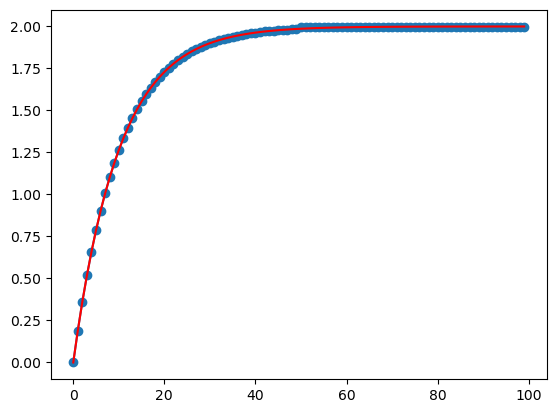

In [89]:
plt.plot(nl_prediction(extend(uopt), dt), '-o', label='Optimized response')
plt.plot(r, 'r', label='Optimized response')
